# Демонстрация регуляризаций  
## Основные моменты  
- L1-регуляризация  
- L2-регуляризация  
- ElasticNet-регуляризация  


Посмотрим, как обычная линейная регрессия справляется с шумом, рассмотрим примеры регуляризаций L1, L2, ElasticNet, а также автоматически подберём гиперпараметры для них.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

Генерация данных: создаём датасет, который подойдёт для тестирования регуляризаций.


In [2]:
np.random.seed(42) 
n = 400

X1 = np.random.uniform(-10, 10, size=n)      
X2 = np.random.normal(0, 1, size=n)             
X3 = np.random.uniform(0, 100, size=n)           
X4 = np.random.normal(50, 5, size=n)             
X5 = np.random.uniform(-1, 1, size=n)            
X6 = np.random.binomial(1, 0.5, size=n) 
X7 = X1 + np.random.normal(0, 0.1, size=n)  # мультиколениарность, когда x7 зависит от x1       
noise = np.random.uniform(-10, 10, size=n)

y = 3.5 * X1 + 2.0 * X4 - 1.2 * X6 + noise + 1.3 # в генерации участвует x1,x4,x6, то есть они реально полезны, а остальные - это шум, мусор, который мы уберем далее
df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4,
    'X5': X5,
    'X6': X6,
    'X7': X7,
    'y': y
})

In [3]:
X = df.drop(columns=['y'])
y = df['y']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Стандартизируем данные
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## Построение и оценка базовой модели

In [6]:
base_model = LinearRegression().fit(X_train, y_train)

pred = base_model.predict(X_test)

In [7]:
mse_base_model = mean_squared_error(y_test, pred)
mae_base_model = mean_absolute_error(y_test, pred)
mape_base_model = mean_absolute_percentage_error(y_test, pred) * 100
rmse_base_model = root_mean_squared_error(y_test, pred)

print(f'mse:{mse_base_model:.2f}|mae{mae_base_model:.2f}|mape:{mape_base_model:.2f}|rmse{rmse_base_model:.2f}')

mse:33.50|mae4.97|mape:5.43|rmse5.79


Метрики показаны выше, зафиксируем их для дальнейшего анализа.

## L1 регуляризация(Lasso)

### Обычная L1 регуляризация без автоматического подбора гиперпараметров

mse:35.30|mae4.96|mape:5.52|rmse5.94


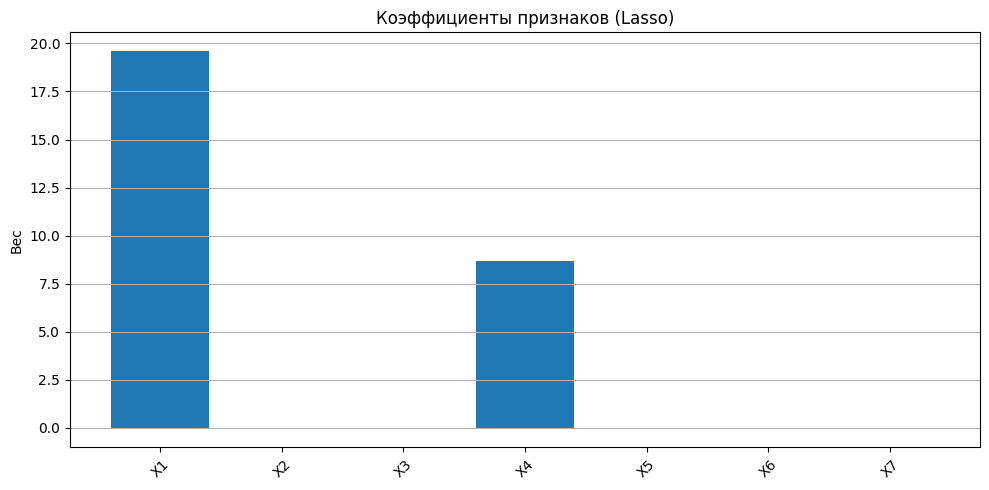

In [8]:
lasso = Lasso(alpha=1).fit(X_train, y_train)

pred_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, pred_lasso)
mae_lasso = mean_absolute_error(y_test, pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, pred_lasso) * 100
rmse_lasso = root_mean_squared_error(y_test, pred_lasso)

print(f'mse:{mse_lasso:.2f}|mae{mae_lasso:.2f}|mape:{mape_lasso:.2f}|rmse{rmse_lasso:.2f}')

plt.figure(figsize=(10, 5))
plt.bar(X.columns, lasso.coef_)
plt.title('Коэффициенты признаков (Lasso)')
plt.ylabel('Вес')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Сверху показаны метрики и столбцы. Модель почти правильно занулила веса, но ошибочно убрала также признак x6. Некоторые метрики при этом ухудшились.

### Автоматический подбор гиперпараметров для Lasso

Не всегда можно угадать с гиперпараметрами регуляризации, поэтому лучше довериться автоматическому подбору с помощью LassoCV.

mse:33.02|mae4.93|mape:5.40|rmse5.75


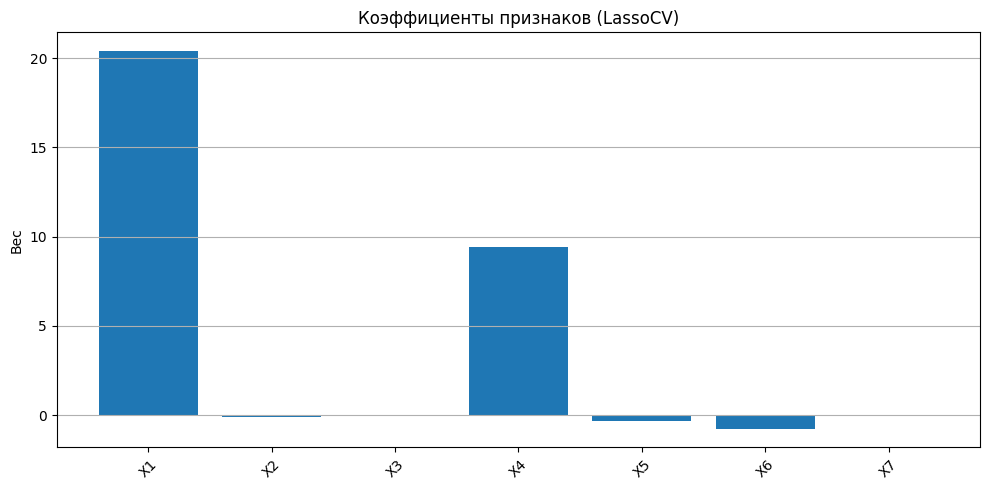

In [9]:
lasso_cv = LassoCV(alphas=np.logspace(-3,3,100), cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)

pred_lasso_cv = lasso_cv.predict(X_test)

mse_lasso_cv = mean_squared_error(y_test, pred_lasso_cv)
mae_lasso_cv = mean_absolute_error(y_test, pred_lasso_cv)
mape_lasso_cv = mean_absolute_percentage_error(y_test, pred_lasso_cv) * 100
rmse_lasso_cv = root_mean_squared_error(y_test, pred_lasso_cv)

print(f'mse:{mse_lasso_cv:.2f}|mae{mae_lasso_cv:.2f}|mape:{mape_lasso_cv:.2f}|rmse{rmse_lasso_cv:.2f}')

plt.figure(figsize=(10, 5))
plt.bar(X.columns, lasso_cv.coef_)
plt.title('Коэффициенты признаков (LassoCV)')
plt.ylabel('Вес')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Метрики почти не изменились по сравнению с базовой линейной регрессией, но зато улучшилась работа Lasso.

## L2 регуляризация (Ridge)

### Обычный Ridge без автоматического подбора

mse:33.80|mae5.00|mape:5.47|rmse5.81


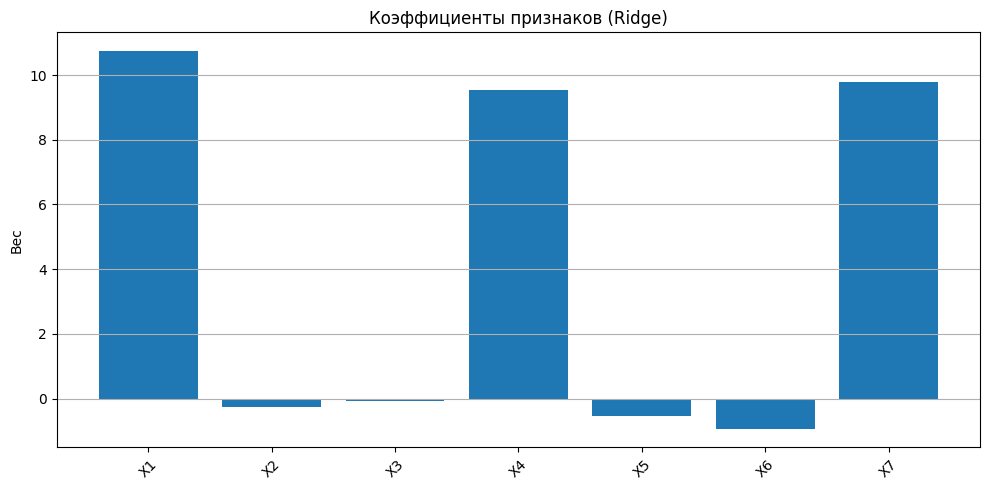

In [10]:
ridge = Ridge(alpha=1).fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, pred_ridge)
mae_ridge = mean_absolute_error(y_test, pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, pred_ridge) * 100
rmse_ridge = root_mean_squared_error(y_test, pred_ridge)

print(f'mse:{mse_ridge:.2f}|mae{mae_ridge:.2f}|mape:{mape_ridge:.2f}|rmse{rmse_ridge:.2f}')

plt.figure(figsize=(10, 5))
plt.bar(X.columns, ridge.coef_)
plt.title('Коэффициенты признаков (Ridge)')
plt.ylabel('Вес')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Автоматический подбор гиперпараметров для Ridge

mse:33.84|mae5.00|mape:5.47|rmse5.82


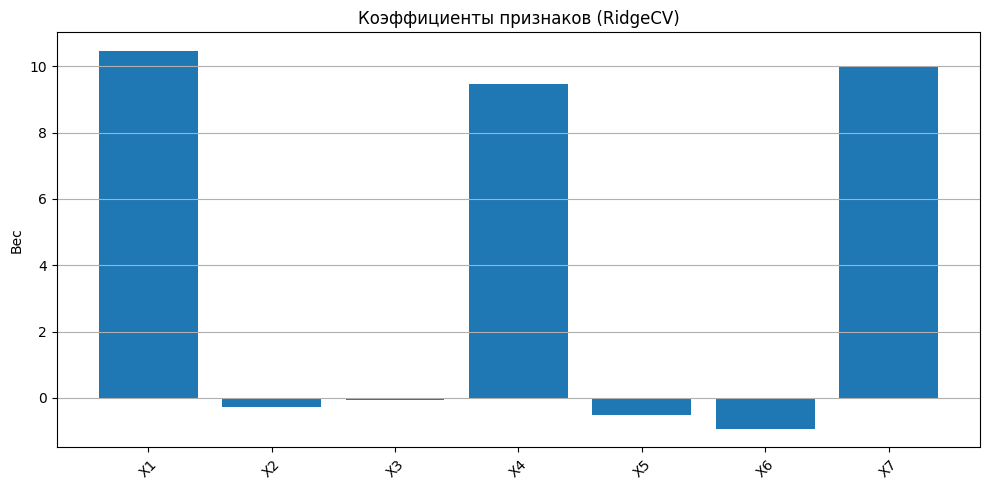

In [11]:
ridge_cv = RidgeCV(alphas=np.logspace(-3,3,100), cv=5).fit(X_train, y_train)

pred_ridge_cv = ridge_cv.predict(X_test)

mse_ridge_cv = mean_squared_error(y_test, pred_ridge_cv)
mae_ridge_cv = mean_absolute_error(y_test, pred_ridge_cv)
mape_ridge_cv = mean_absolute_percentage_error(y_test, pred_ridge_cv) * 100
rmse_ridge_cv = root_mean_squared_error(y_test, pred_ridge_cv)

print(f'mse:{mse_ridge_cv:.2f}|mae{mae_ridge_cv:.2f}|mape:{mape_ridge_cv:.2f}|rmse{rmse_ridge_cv:.2f}')

plt.figure(figsize=(10, 5))
plt.bar(X.columns, ridge_cv.coef_)
plt.title('Коэффициенты признаков (RidgeCV)')
plt.ylabel('Вес')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На самом деле Ridge здесь не самый лучший инструмент — в этой задаче нам нужно занулять ненужные веса, а Ridge этого сделать не может.

## ElasticNet регуляризация

### Обычная ElasticNet регуляризация

mse:35.30|mae4.96|mape:5.52|rmse5.94


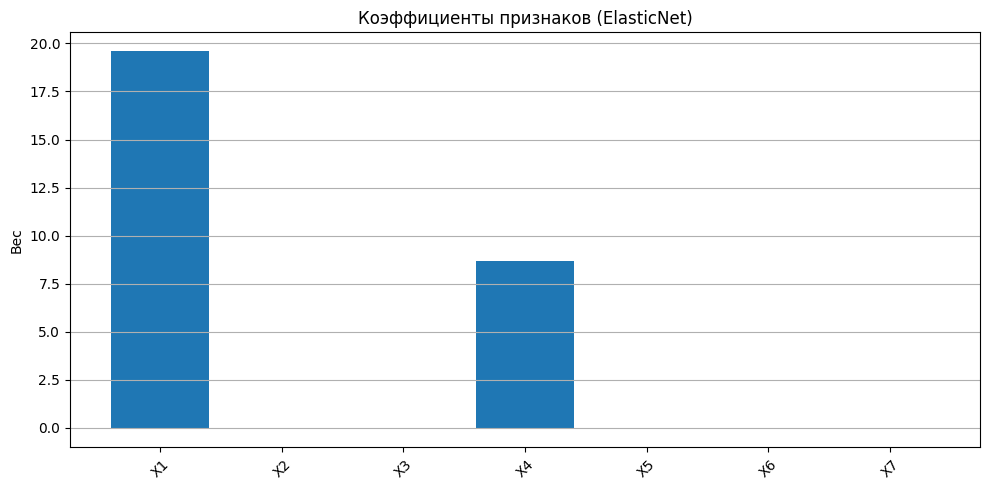

In [12]:
el = ElasticNet(alpha=1, l1_ratio=1).fit(X_train, y_train)

pred_el = el.predict(X_test)

mse_el = mean_squared_error(y_test, pred_el)
mae_el = mean_absolute_error(y_test, pred_el)
mape_el = mean_absolute_percentage_error(y_test, pred_el) * 100
rmse_el = root_mean_squared_error(y_test, pred_el)

print(f'mse:{mse_el:.2f}|mae{mae_el:.2f}|mape:{mape_el:.2f}|rmse{rmse_el:.2f}')

plt.figure(figsize=(10, 5))
plt.bar(X.columns, el.coef_)
plt.title('Коэффициенты признаков (ElasticNet)')
plt.ylabel('Вес')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Автоматический подбор гиперпараметров для ElasticNet

mse:33.41|mae4.95|mape:5.44|rmse5.78


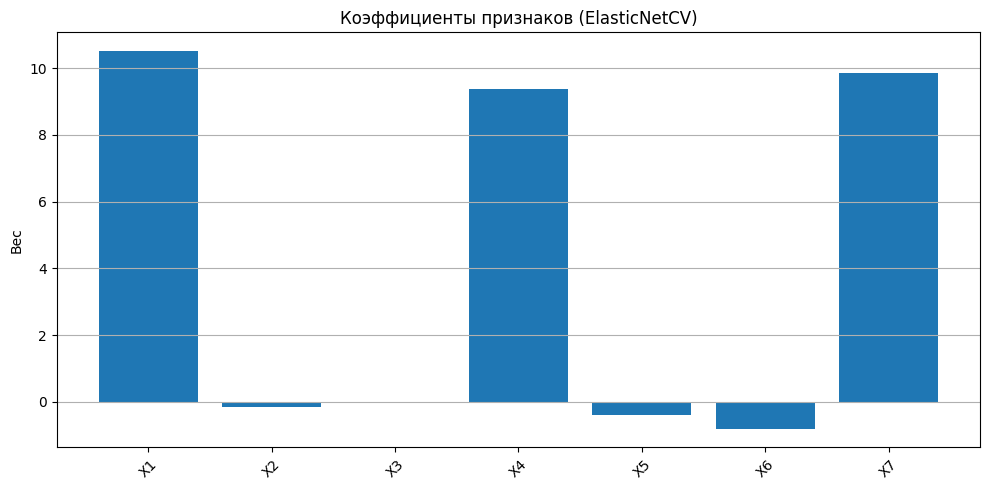

In [13]:
el_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, 1], alphas=np.logspace(-2, 2, 100), cv=5, random_state=42).fit(X_train, y_train)

pred_el_cv = el_cv.predict(X_test)

mse_el_cv = mean_squared_error(y_test, pred_el_cv)
mae_el_cv = mean_absolute_error(y_test, pred_el_cv)
mape_el_cv = mean_absolute_percentage_error(y_test, pred_el_cv) * 100
rmse_el_cv = root_mean_squared_error(y_test, pred_el_cv)

print(f'mse:{mse_el_cv:.2f}|mae{mae_el_cv:.2f}|mape:{mape_el_cv:.2f}|rmse{rmse_el_cv:.2f}')

plt.figure(figsize=(10, 5))
plt.bar(X.columns, el_cv.coef_)
plt.title('Коэффициенты признаков (ElasticNetCV)')
plt.ylabel('Вес')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
print(f"""
┌─────────────────────────────┬────────┬────────┬────────┬────────┐
│        Модель               │  MSE   │  RMSE  │  MAE   │  MAPE  │
├─────────────────────────────┼────────┼────────┼────────┼────────┤
│ L1 (Lasso)                  │ {mse_lasso:.3f}  │ {rmse_lasso:.3f}  │ {mae_lasso:.3f}  │ {mape_lasso:.2f}% │
│ L1 (LassoCV)                │ {mse_lasso_cv:.3f}  │ {rmse_lasso_cv:.3f}  │ {mae_lasso_cv:.3f}  │ {mape_lasso_cv:.2f}% │
├─────────────────────────────┼────────┼────────┼────────┼────────┤
│ L2 (Ridge)                  │ {mse_ridge:.3f}  │ {rmse_ridge:.3f}  │ {mae_ridge:.3f}  │ {mape_ridge:.2f}% │
│ L2 (RidgeCV)                │ {mse_ridge_cv:.3f}  │ {rmse_ridge_cv:.3f}  │ {mae_ridge_cv:.3f}  │ {mape_ridge_cv:.2f}% │
├─────────────────────────────┼────────┼────────┼────────┼────────┤
│ ElasticNet                  │ {mse_el:.3f}  │ {rmse_el:.3f}  │ {mae_el:.3f}  │ {mape_el:.2f}% │
│ ElasticNetCV                │ {mse_el_cv:.3f}  │ {rmse_el_cv:.3f}  │ {mae_el_cv:.3f}  │ {mape_el_cv:.2f}% │
└─────────────────────────────┴────────┴────────┴────────┴────────┘
""")



┌─────────────────────────────┬────────┬────────┬────────┬────────┐
│        Модель               │  MSE   │  RMSE  │  MAE   │  MAPE  │
├─────────────────────────────┼────────┼────────┼────────┼────────┤
│ L1 (Lasso)                  │ 35.296  │ 5.941  │ 4.958  │ 5.52% │
│ L1 (LassoCV)                │ 33.021  │ 5.746  │ 4.925  │ 5.40% │
├─────────────────────────────┼────────┼────────┼────────┼────────┤
│ L2 (Ridge)                  │ 33.798  │ 5.814  │ 4.996  │ 5.47% │
│ L2 (RidgeCV)                │ 33.840  │ 5.817  │ 4.995  │ 5.47% │
├─────────────────────────────┼────────┼────────┼────────┼────────┤
│ ElasticNet                  │ 35.296  │ 5.941  │ 4.958  │ 5.52% │
│ ElasticNetCV                │ 33.408  │ 5.780  │ 4.955  │ 5.44% │
└─────────────────────────────┴────────┴────────┴────────┴────────┘

